<a href="https://colab.research.google.com/github/Geological-Survey-Ireland/Hyperspectral/blob/main/5_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clustering**

This notebook will look at two different methods of clustering the data; [Self-organising maps](https://en.wikipedia.org/wiki/Self-organizing_map) (SOM) and [*k*-means clustering](https://en.wikipedia.org/wiki/K-means_clustering).


We will use the continuum removed data generated in notebook [4](https://github.com/Geological-Survey-Ireland/Hyperspectral/blob/main/4_Removing_the_continuum.ipynb) to perform the clustering. We will use the spectral python implementation of *k*-means and the [Minisom](https://github.com/JustGlowing/minisom) library for the SOM

In [ ]:

!pip install spectral
!pip install minisom

import spectral as sp
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import minisom as ms


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9016 sha256=6bbee9be9002110ed5b50e8ea9dac7e15858e1c44f8d57aa93882e441bd7124b
  Stored in directory: /root/.cache/pip/wheels/6d/4e/9e/a95c14a232a196c22d9c04b221ff5d25461a1a4c55339c61db
Successfully built minisom


We will need to open the continuum removed data generated in notebook [4](https://github.com/Geological-Survey-Ireland/Hyperspectral/blob/main/4_Removing_the_continuum.ipynb).


In [ ]:
# Use numpy to open the continuum removed dataset
data = np.load('/content/drive/MyDrive/Public/Sample_Data_cr_seg.npy')
# We will also want the bands file for plotting later
bands = np.load('/content/drive/MyDrive/Public/Clipped_Bands.npy')


***k*-Means.**

We will start with the *k*-means algorithm.


The spectral *k*-means returns the cluster centres and an array of labels with the same shape as the input.

In [ ]:
#labels is the array of labels, centres is the cluster centres
#the sp.kmeans call requires three arguments; the data to be clustered,
#the number of clusters, and the number of iterations
labels, centres = sp.kmeans(data, 15, 100)
print(labels.shape)
print(centres.shape)

spectral:INFO: k-means iteration 1 - 108387 pixels reassigned.
INFO:spectral:k-means iteration 1 - 108387 pixels reassigned.
spectral:INFO: k-means iteration 2 - 1916 pixels reassigned.
INFO:spectral:k-means iteration 2 - 1916 pixels reassigned.
spectral:INFO: k-means iteration 3 - 3243 pixels reassigned.
INFO:spectral:k-means iteration 3 - 3243 pixels reassigned.
spectral:INFO: k-means iteration 4 - 3352 pixels reassigned.
INFO:spectral:k-means iteration 4 - 3352 pixels reassigned.
spectral:INFO: k-means iteration 5 - 1173 pixels reassigned.
INFO:spectral:k-means iteration 5 - 1173 pixels reassigned.
spectral:INFO: k-means iteration 6 - 1621 pixels reassigned.
INFO:spectral:k-means iteration 6 - 1621 pixels reassigned.
spectral:INFO: k-means iteration 7 - 2034 pixels reassigned.
INFO:spectral:k-means iteration 7 - 2034 pixels reassigned.
spectral:INFO: k-means iteration 8 - 2736 pixels reassigned.
INFO:spectral:k-means iteration 8 - 2736 pixels reassigned.
spectral:INFO: k-means itera

(3613, 30)
(15, 249)


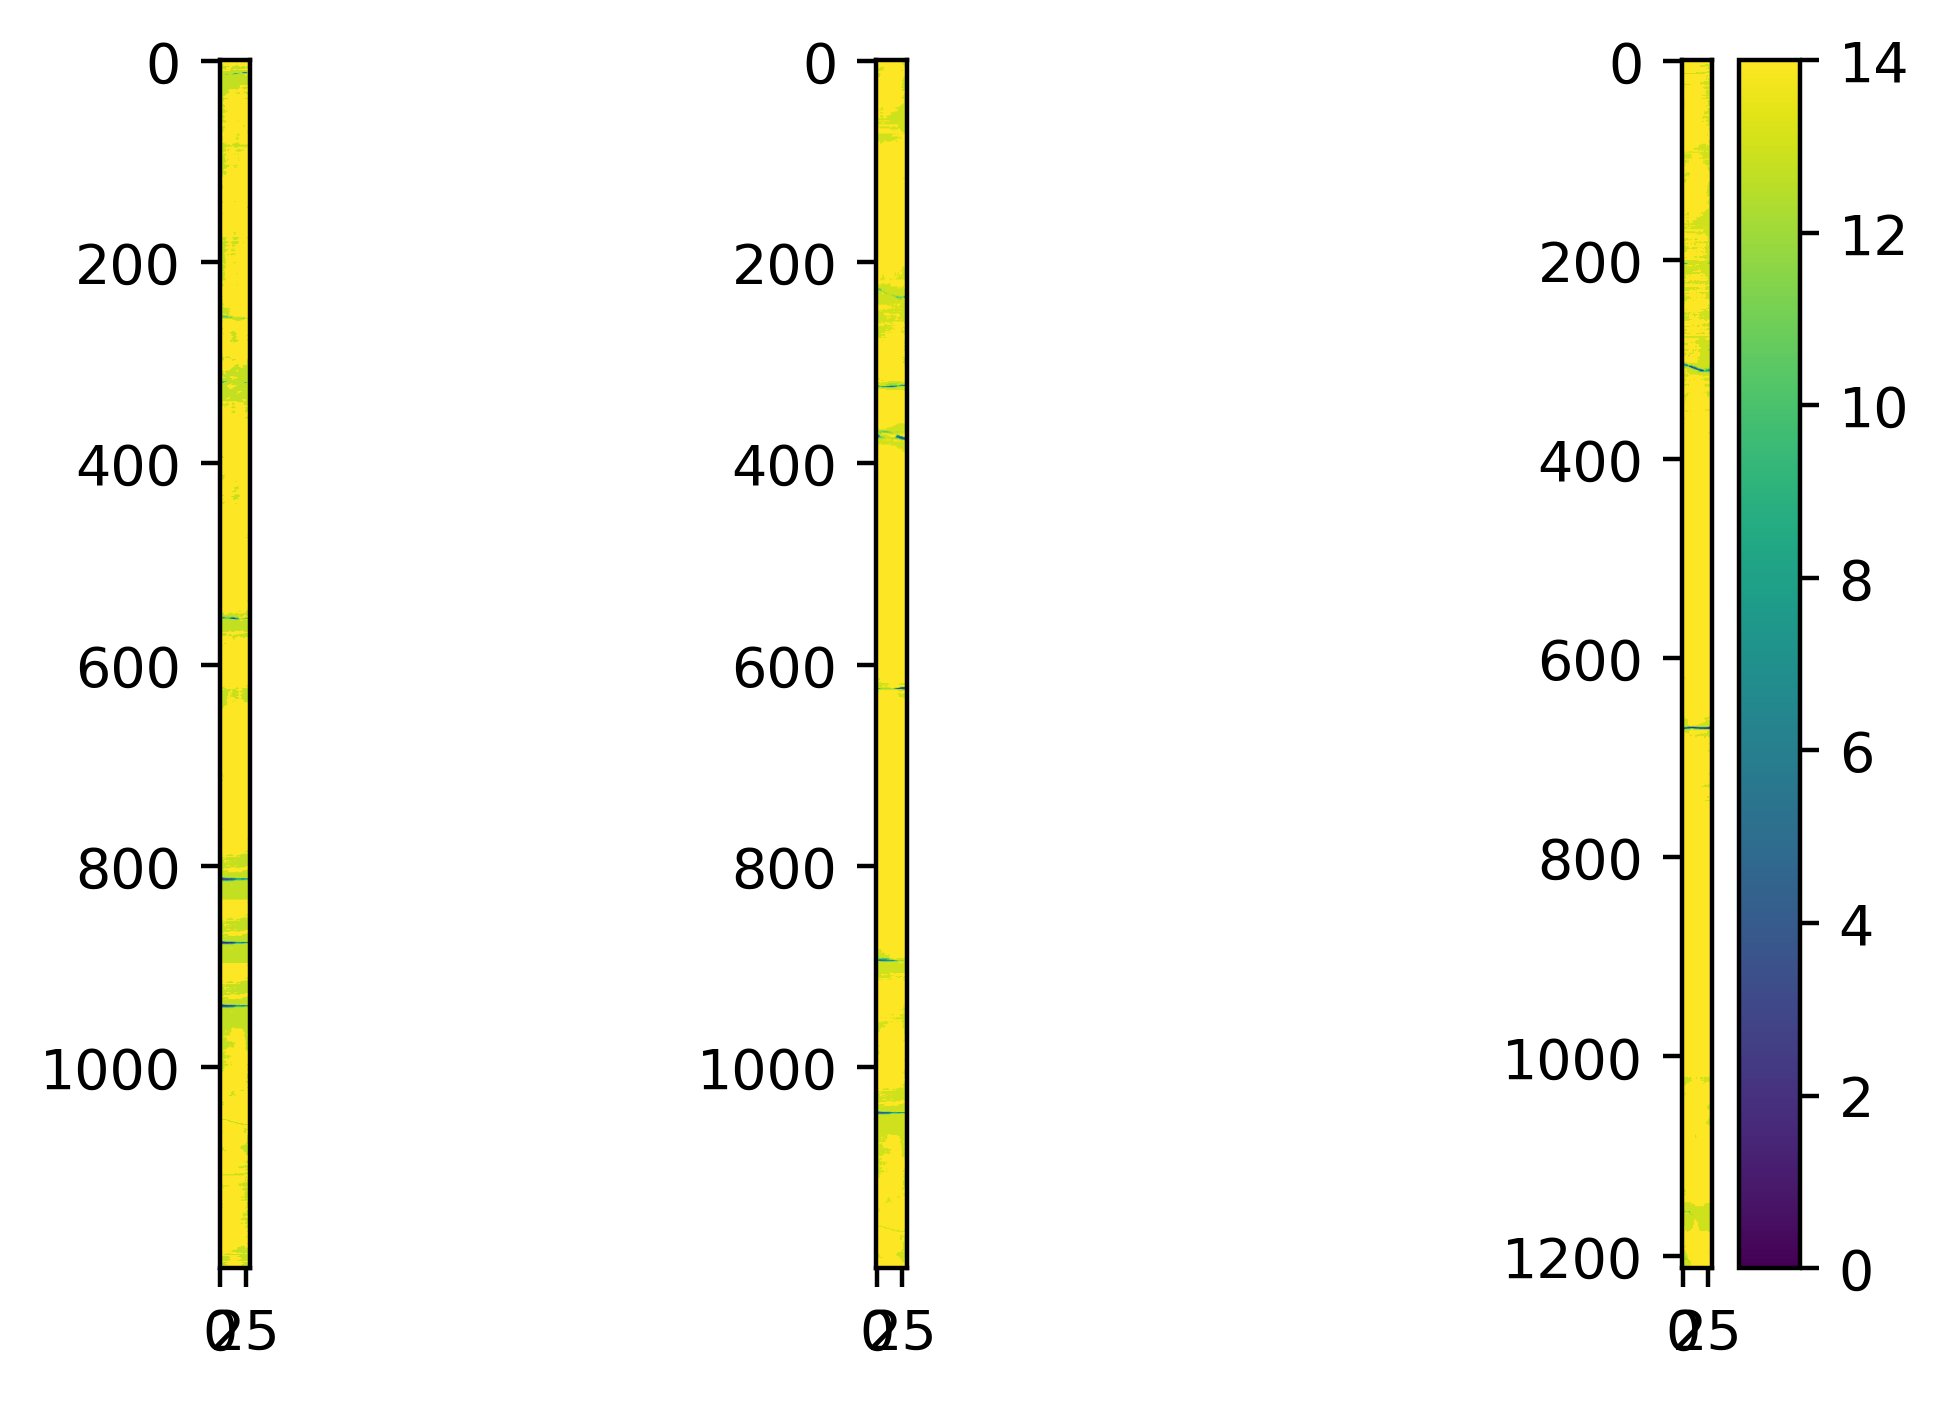

In [ ]:
#We can now plot the labels. This is split into three separate images 
#to make it easier to see

#change the figure paramaters to make it larger
plt.rcParams['figure.dpi'] = 400
plt.figure()
#in the first subplot, plot the first third of the dataset
plt.subplot(131)
plt.imshow(labels[0:1200])
#in the second subplot, plot the second third of the dataset
plt.subplot(132)
plt.imshow(labels[1200:2400])
#in the third subplot, plot the final third of the dataset
plt.subplot(133)
plt.imshow(labels[2400:])
#plot the colourbar NB the US spelling in matplotlib syntax
plt.colorbar()


We can see from our three images that are dataset is dominated by clusters 13 and 14, with most other clusters formed from the noisy data representing cracks in the core.

We can examine the data more closely using the numpy [bincounts](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) method, which counts the number of occurences in an array.

In [ ]:
#numpy bincounts only accepts 1D arrays, so we will need to reshape our data again
counts = np.bincount(np.reshape(labels,(-1)))
#printing the index and counts to see which is most dominant
for i in range(len(counts)):
  print(str(i) + ':', counts[i])

0: 3
1: 10
2: 11
3: 33
4: 77
5: 30
6: 42
7: 65
8: 83
9: 63
10: 102
11: 169
12: 469
13: 20380
14: 86853


The bincount confirms that the data is overwhelmingly dominated by clusters 13 and 14 as seen in the colourmaps above.

We can examine these clusters by plotting the centres against bands.

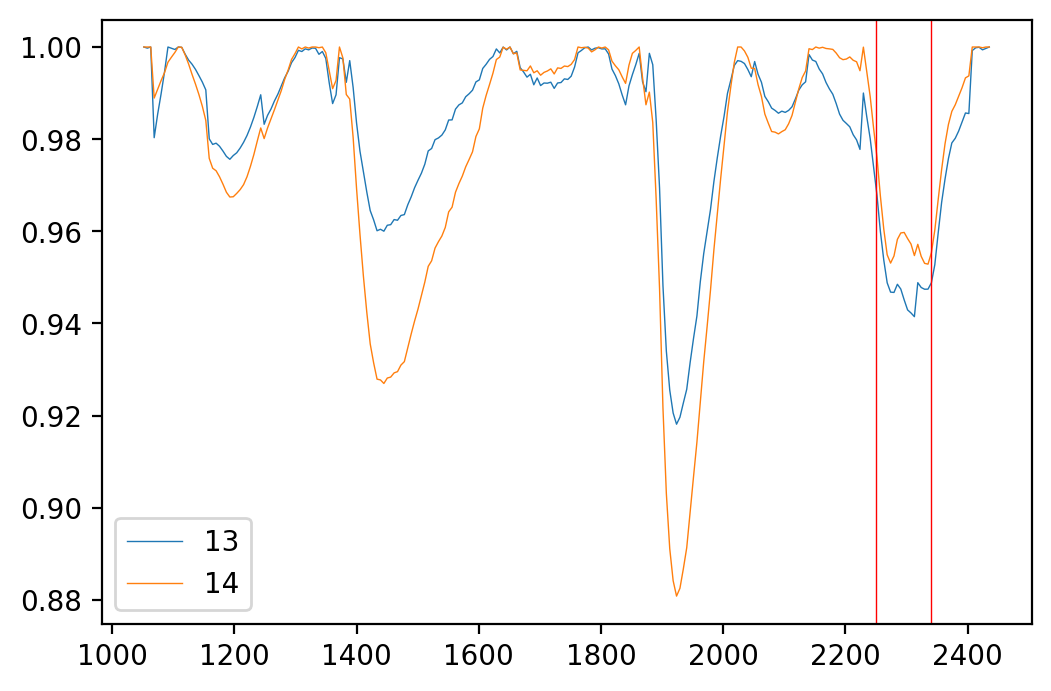

In [ ]:
#alter the figure size for best viewing
plt.rcParams['figure.dpi'] = 200
plt.figure()
#plot cluster centers against bands
plt.plot(bands, centres[13], label = 13, linewidth=0.5)
plt.plot(bands, centres[14], label = 14, linewidth=0.5)
#vertical lines at given bandwidths
plt.axvline(x=2250, color='r', linewidth=0.5)
plt.axvline(x=2340, color='r', linewidth=0.5)
plt.legend()


You can see that clusters 13 and 14 are largely similar with a few differences. I have highlighted the region between 2250 and 2340nm as we know that this dataset is carbonate rock and this region contains a diagnostic absorbtion feature of carbonate minerals.

**SOM Clustering**

SOM is an unsupervised machine learning technique used to produce a low-dimensional, in this case two-dimensional, representation of a higher dimensional data set.

In [ ]:
#the SOM object will only accept 2D arrays, so we need to reshape our data so
#each pixel is a point.

#reshape the data
trainset = np.reshape(data, (-1, data.shape[-1]))
print(trainset.shape)

(108390, 249)


In [ ]:
#create the SOM, specifying rows, columns, data and distance method.
#in this case we have used the cosine distance method, which calulated the angle
#rows x columns = number of nodes
#3 rows and 5 columns gives us 15 nodes, as in k-means above
som = ms.MiniSom(3,5,trainset.shape[-1], activation_distance='cosine')
#initialize the weights using the data
som.random_weights_init(trainset)
#train the SOM using the data
som.train(trainset, num_iteration=1000)
# weights are the dataset for each nodes, as the cluster centres above
weights = som.get_weights() 
# reshape the weights to 2 dimensions
weights = np.reshape(weights, (-1, trainset.shape[-1]))
# Treat each node as a cluster centre and use it to label each pixel in the dataset
labels = np.array([som.winner(x) for x in trainset]).T 
#convert the SOM map coordinates to a flat index
labels = np.ravel_multi_index(labels, (3,5))
#reshape the labels to match the original dataset x and y
labels = np.reshape(labels, (data.shape[0], -1))

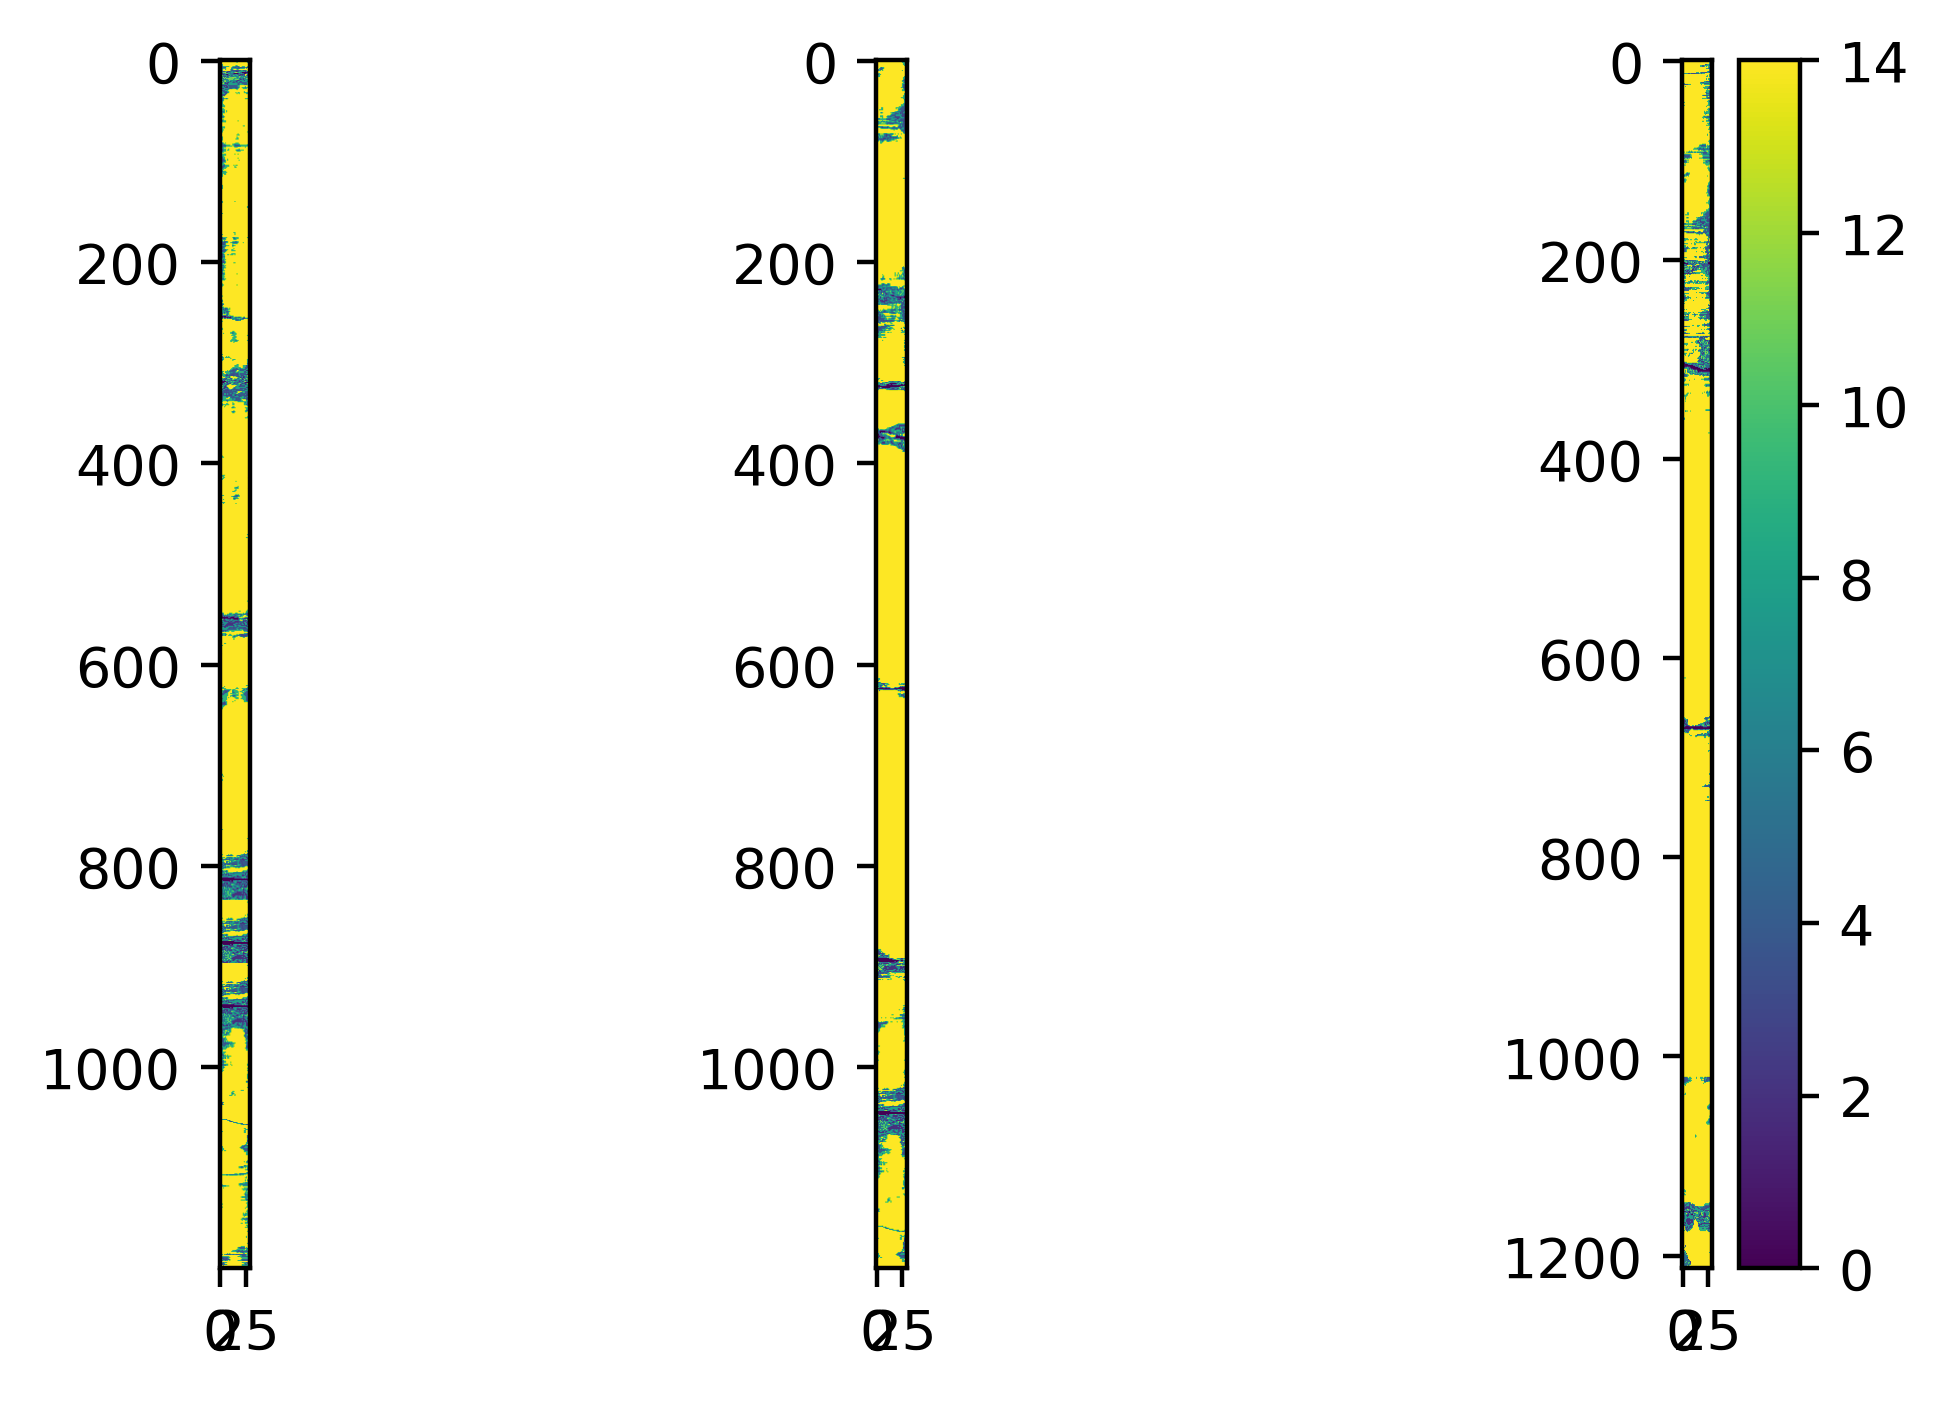

In [ ]:
#We can now plot the labels. This is split into three separate images 
#to make it easier to see

#change the figure paramaters to make it larger
plt.rcParams['figure.dpi'] = 400
plt.figure()
#in the first subplot, plot the first third of the dataset
plt.subplot(131)
plt.imshow(labels[0:1200])
#in the second subplot, plot the second third of the dataset
plt.subplot(132)
plt.imshow(labels[1200:2400])
#in the third subplot, plot the final third of the dataset
plt.subplot(133)
plt.imshow(labels[2400:])
#plot the colourbar NB the US spelling in matplotlib syntax
plt.colorbar()

The clustering using SOM is significantly different to the *k*-means, and more clusters are represented. We can use the Numpy bincounts call to see which indexes are the most represented

In [ ]:
#numpy bincounts only accepts 1D arrays, so we will need to reshape our data again
counts = np.bincount(np.reshape(labels,(-1)))
#printing the index and counts to see which is most dominant
for i in range(len(counts)):
  print(str(i) + ':', counts[i])

0: 950
1: 26
2: 1821
3: 2143
4: 4608
5: 638
6: 586
7: 1076
8: 2221
9: 6600
10: 345
11: 302
12: 221
13: 0
14: 86853


It can be seen that cluster 14 is clearly dominant (as confirmed by the colourmap above), followed by clusters 9 and 4.
So, let us look at those three cluster centres

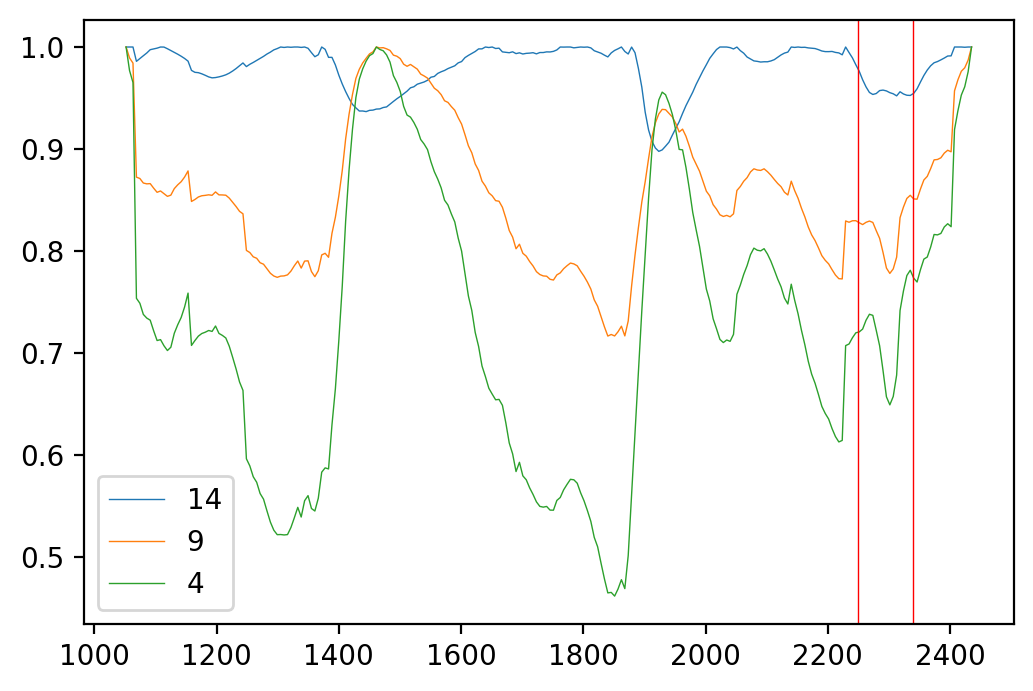

In [ ]:
#alter the figure size for best viewing
plt.rcParams['figure.dpi'] = 200
plt.figure()
#plot cluster centers against bands
plt.plot(bands, weights[14], label = 14, linewidth=0.5)
plt.plot(bands, centres[9], label = 9, linewidth=0.5)
plt.plot(bands, centres[4], label = 4, linewidth=0.5)
#vertical lines at given bandwidths
plt.axvline(x=2250, color='r', linewidth=0.5)
plt.axvline(x=2340, color='r', linewidth=0.5)
plt.legend()

These cluster centres are significantly different to the *k*-means centres. 

Again I have highlighted the known carbonate diagnostic region.

Many of the parameters can be changed in the MiniSom implementation. Let us run it again using the euclidean distance method.



0: 713
1: 0
2: 1502
3: 1487
4: 2145
5: 237
6: 628
7: 43
8: 2153
9: 11208
10: 207
11: 691
12: 523
13: 0
14: 86853


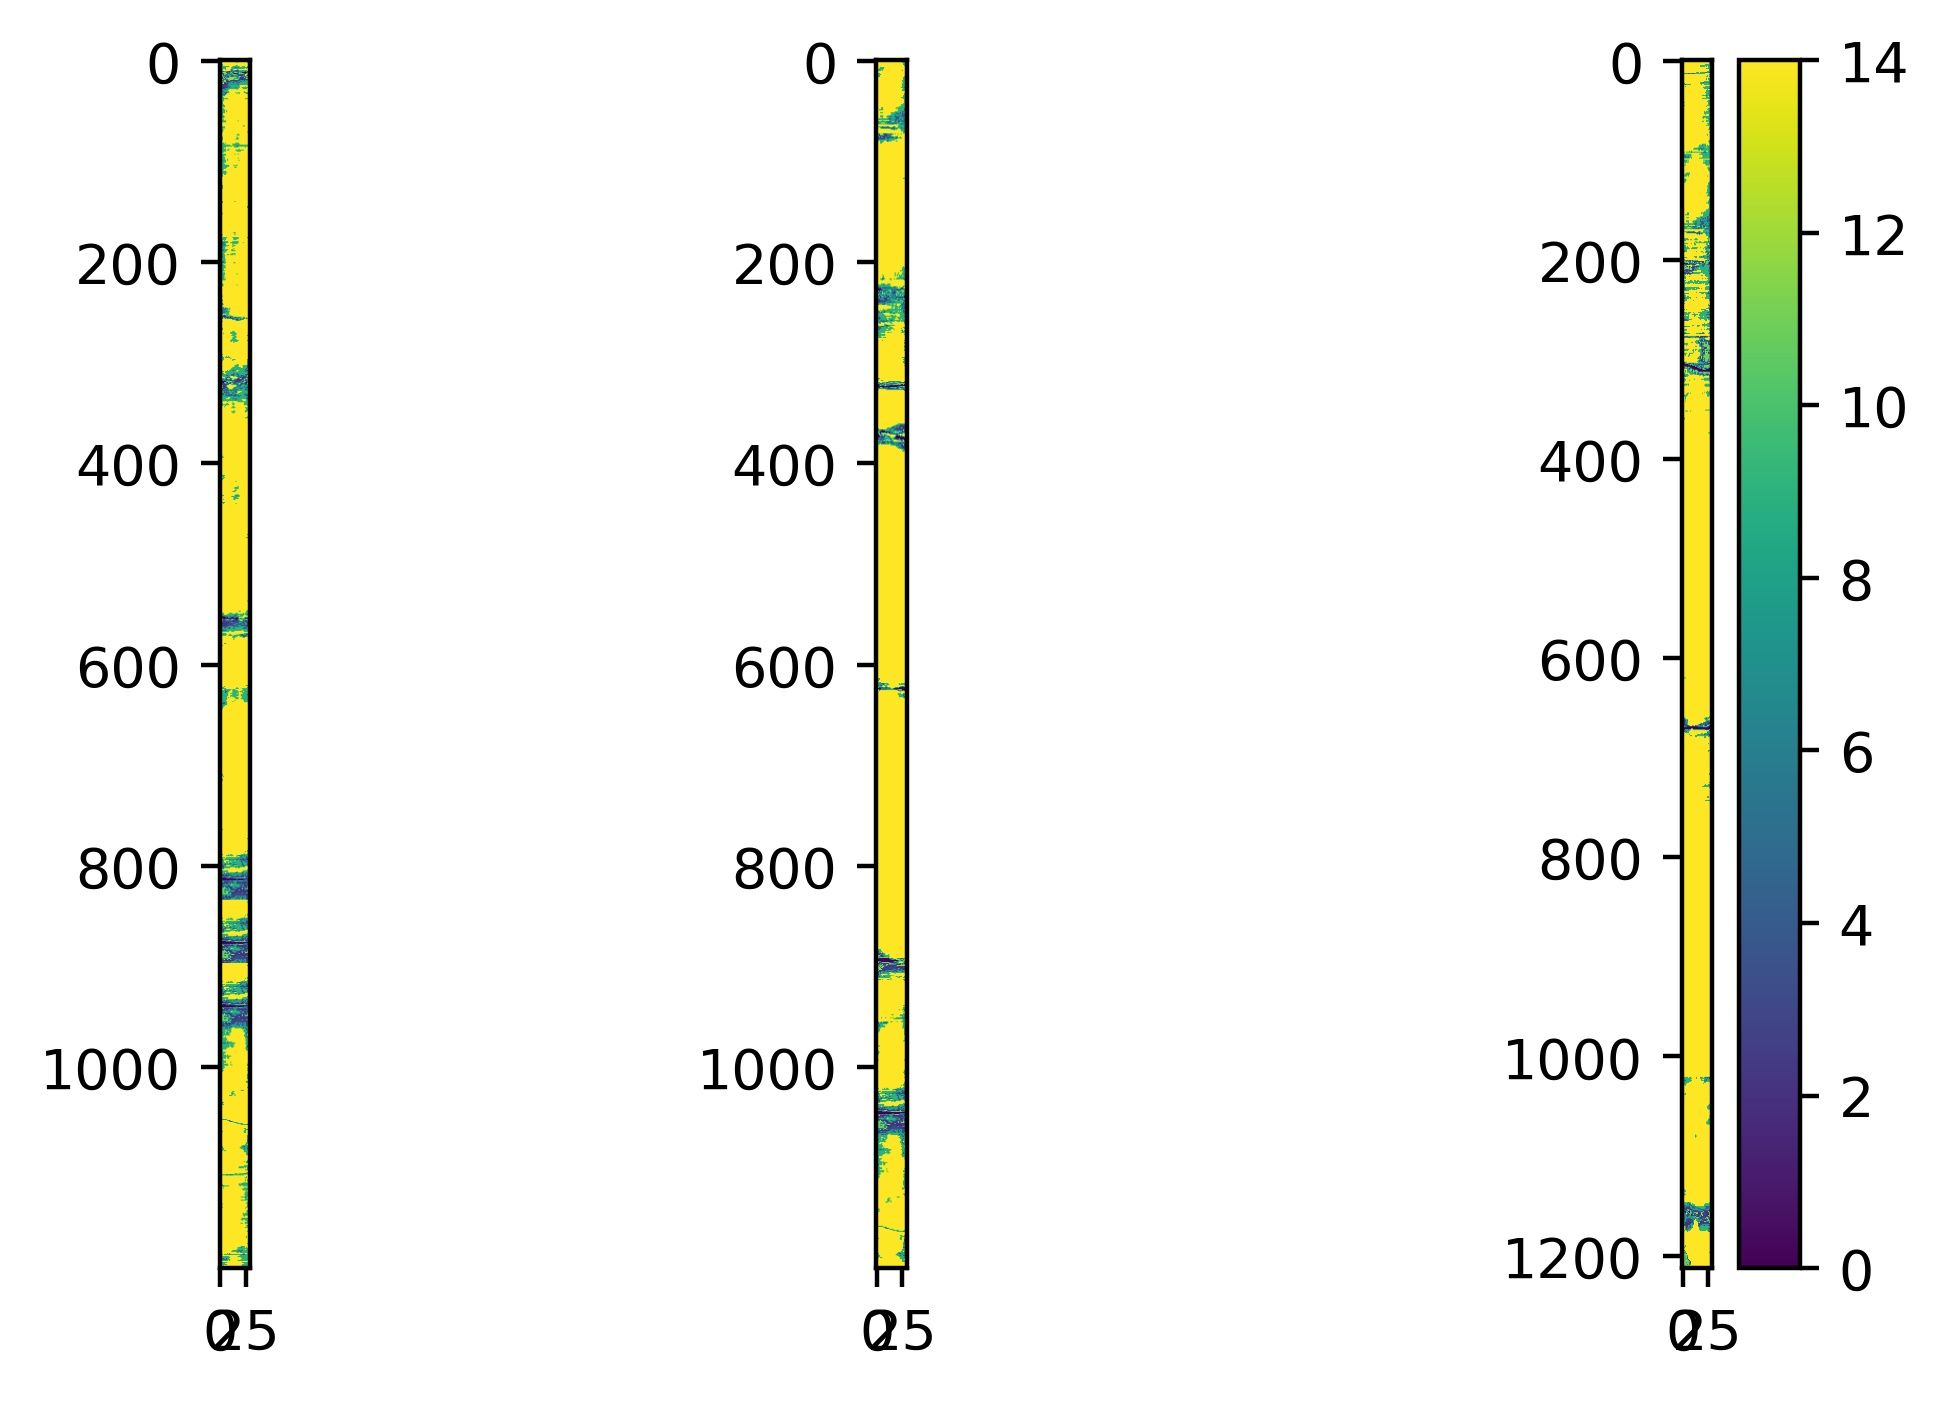

In [ ]:
#create the SOM, specifying rows, columns, data and distance method.
#in this case we have used the cosine distance method, which calulated the angle
#rows x columns = number of nodes
#3 rows and 5 columns gives us 15 nodes, as in k-means above
som = ms.MiniSom(3,5,trainset.shape[-1], activation_distance='euclidean')
#initialize the weights using the data
som.random_weights_init(trainset)
#train the SOM using the data
som.train(trainset, num_iteration=1000)
# weights are the dataset for each nodes, as the cluster centres above
weights = som.get_weights() 
# reshape the weights to 2 dimensions
weights = np.reshape(weights, (-1, trainset.shape[-1]))
# Treat each node as a cluster centre and use it to label each pixel in the dataset
labels = np.array([som.winner(x) for x in trainset]).T 
#convert the SOM map coordinates to a flat index
labels = np.ravel_multi_index(labels, (3,5))
#reshape the labels to match the original dataset x and y
labels = np.reshape(labels, (data.shape[0], -1))

#We can now plot the labels. This is split into three separate images 
#to make it easier to see

#change the figure paramaters to make it larger
plt.rcParams['figure.dpi'] = 400
plt.figure()
#in the first subplot, plot the first third of the dataset
plt.subplot(131)
plt.imshow(labels[0:1200])
#in the second subplot, plot the second third of the dataset
plt.subplot(132)
plt.imshow(labels[1200:2400])
#in the third subplot, plot the final third of the dataset
plt.subplot(133)
plt.imshow(labels[2400:])
#plot the colourbar NB the US spelling in matplotlib syntax
plt.colorbar()

#numpy bincounts only accepts 1D arrays, so we will need to reshape our data again
counts = np.bincount(np.reshape(labels,(-1)))
#printing the index and counts to see which is most dominant
for i in range(len(counts)):
  print(str(i) + ':', counts[i])

This time, nodes 14 and 9 are the most dominant. Lets plot them and see

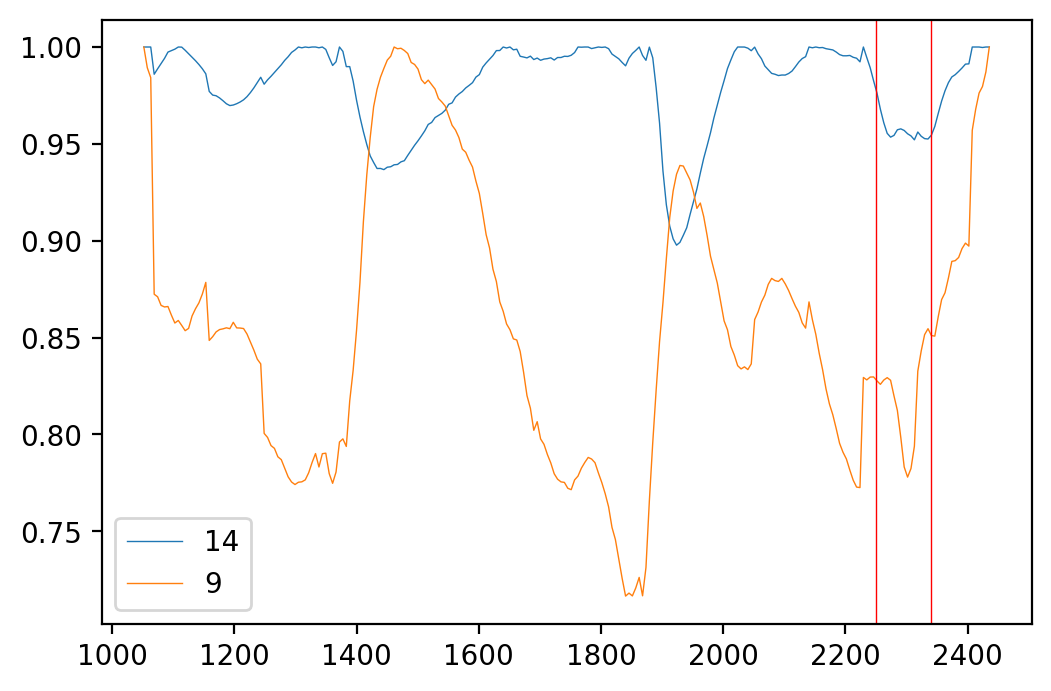

In [ ]:
#alter the figure size for best viewing
plt.rcParams['figure.dpi'] = 200
plt.figure()
#plot cluster centers against bands
plt.plot(bands, weights[14], label = 14, linewidth=0.5)
plt.plot(bands, centres[9], label = 9, linewidth=0.5)

#vertical lines at given bandwidths
plt.axvline(x=2250, color='r', linewidth=0.5)
plt.axvline(x=2340, color='r', linewidth=0.5)
plt.legend()